# Model comparison between comparing activity using th e"Social" v. "Non-social" (user-defined) labels and experimenter-assigned labels

This was done to directly test whether the use of observer labels (subjective) fits the neural data better than experimenter-assigned labels (objective).

Rekha Varrier, 2022

In [1]:
# import general packages, check folders
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time
from pathlib import Path


%matplotlib inline
working_dir = '/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code'
print('current directory:\n',working_dir)
path = Path(working_dir)
parent_folder = path.parent
data_file_loc = os.path.join(parent_folder,'data') # to store data we extract later in this notebook

current directory:
 /Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code


In [2]:
# setting default fontsizes for plots
s=16 # CHANGE FONTSIZE HERE
plt.rc('font', size=s) #controls default text size
plt.rc('axes', titlesize=s) #fontsize of the title
plt.rc('axes', labelsize=s) #fontsize of the x and y labels
plt.rc('xtick', labelsize=s) #fontsize of the x tick labels
plt.rc('ytick', labelsize=s) #fontsize of the y tick labels
plt.rc('legend', fontsize=s) #fontsize of the legend

In [3]:
#suff= ' '
suff = '_corrected'

In [4]:
# load behavioral data - coded 1 for "social", 0 for "nonsocial" and 9 for "unsure", nan for missed response
# even if using the Mental/Random labels, need this to sub-select subs who have responded on all trials
responses = np.load(os.path.join(data_file_loc,f'responses{suff}.npy'))
responses.shape # dimensions: nsubjects * nmovies

(1049, 10)

In [ ]:
print('Nr of subs with all 10 responses:',len(np.where(np.array([len(np.where(~np.isnan(responses[s,:]))[0]) for s in range(responses.shape[0])])==10)[0]))
print('total subs:', responses.shape[0])

# LME stim label vs. response label

In [8]:
vidnames = ["COAXING-B", "BILLIARD-A", "DRIFTING-A", "Fishing", "Random mechanical","Scaring", "SEDUCING-B", "STAR-A", "SURPRISING-B", "TENNIS-A"]

# creating a 3D array of beta coeffs across movies from individual movie files
all_coefs = np.zeros((responses.shape[0],268,10))

for m in range(10): # 10 movies
    fileName =  os.path.join(data_file_loc,'coefs_run_norm','slope_reg',f'coef_slopereg_runnorm_{vidnames[m]}{suff}.npy')
    all_coefs[:,:,m] = np.load(fileName) # each movie stored in a nsubs*nROIs*nmovies array
    #print(dat.shape)

all_coefs[:10,0,:2]

array([[ 9.33693863e-01,  1.66709840e-01],
       [ 2.46438372e+00,  6.79413212e-01],
       [-4.82038901e-01, -6.60210885e-01],
       [ 9.71036189e-01,  1.97436306e+00],
       [-8.99258171e-01, -2.68430814e-01],
       [ 6.55118512e-01, -1.78271651e-03],
       [ 1.27985989e+00, -7.11127922e-01],
       [ 5.54624492e-01,  1.54513876e-01],
       [ 9.87224895e-01,  2.01677021e+00],
       [ 6.72424811e-02,  4.51586746e-01]])

In [9]:
# first of all, best to remove subjects with < 10 responses for power in general
count_resp = np.zeros((responses.shape[0],))
for i in range(responses.shape[0]):
    count_resp[i] = len(np.where(~np.isnan(responses[i,:]))[0])
subs_10resp = np.where(count_resp == 10)[0]
len(subs_10resp)

814

In [10]:
#install lme functions
from pymer4.models import Lmer
import time
from datetime import datetime
stimType = [1,0,0,1,0,1,1,0,1,0]

In [11]:
# initializing arrays to store some values in

coef_ALL_stim, coef_ALL_resp = [np.empty((268,)) for _ in range(2)]
coef_ALL_stim[:], coef_ALL_resp[:] = [np.nan]*2

pval_ALL_stim, pval_ALL_resp = [np.empty((268,)) for _ in range(2)]
pval_ALL_stim[:], pval_ALL_resp[:] = [np.nan]*2

AIC_ALL_stim, AIC_ALL_resp = [np.empty((268,)) for _ in range(2)] # AIC will be the metric to compare the two types of models for each node
AIC_ALL_stim[:], AIC_ALL_resp[:] = [np.nan]*2

In [12]:
# STMTYPE BASED (i.e., experimenter labels, Mental vs. Random)
load_all = 1 # 1: load saved coefs, 0: run the LME
if load_all == 1:
     df_all_coefs = pd.read_csv(os.path.join(data_file_loc,'coefs_run_norm','slope_reg','LME_S_NS_revision1','lmecoefs_all_S_NS_stimType.csv'))
     #[coef_ALL_stim,pval_ALL_stim] = np.load(os.path.join(data_file_loc,'coefs_run_norm','slope_reg','LME_S_NS_revision1','lmecoefs_all_S_NS_stimType.npy'), allow_pickle=True)
else:
    start_time =  time.time()
    for n in range(268):
        if n%10 == 0:
            print(f'node {n+1},time={(time.time()-start_time)/60:.2f} mins')
        
        df = pd.DataFrame(columns = ['coefs','stimType','subID','movie'])
        for m in range(10):
            df_temp = pd.DataFrame({'coefs': all_coefs[subs_10resp,n,m],'stimType':stimType[m], 'response':responses[subs_10resp,m],'subID':subs_10resp,\
                 'movie':np.repeat(m,len(subs_10resp))})
            df = df.append(df_temp,ignore_index=True)
            df = df.loc[df['response'] != 9] # yes v no
        
        df['stimType'] = df['stimType'].map({1.0: "Mental", 0.0:  "Random"})
        df['response'] = df['response'].map({1.0: "Non-social", 0.0:  "Social"})
        
        # experimenter labels to fit neural data (reg coeffts to slope regressor)
        model1 = Lmer('coefs ~  stimType +(1|subID) + (1|movie)', data=df) # ff: mean response, rf:subjID
        model1.fit(factors={"stimType":["Random","Mental"]},summary = False, verbose = False)
        
        # participant responses to fit neural data (reg coeffts to slope regressor)
        model2 = Lmer('coefs ~  response +(1|subID) + (1|movie)', data=df) # ff: mean response, rf:subjID
        model2.fit(factors={"response":["Non-social","Social"]},summary = False, verbose = False)

        if n == 0:
            print('model:',model1.fit(factors={"stimType":["Random","Mental"]}))
            print('model:',model2.fit(factors={"response":["Non-social","Social"]}))

        coef_ALL_stim[n] = model1.coefs['Estimate'][1] # experimenter labels
        pval_ALL_stim[n]= model1.coefs['P-val'][1]
        AIC_ALL_stim[n]= model1.AIC

        coef_ALL_resp[n] = model2.coefs['Estimate'][1] # participant responses- model
        pval_ALL_resp[n]= model2.coefs['P-val'][1]
        AIC_ALL_resp[n]= model2.AIC
        
    df_all_coefs = pd.DataFrame({'Node': np.arange(268), 'coef_stim': coef_ALL_stim, 'pval_stim': pval_ALL_stim, 'AIC_stim': AIC_ALL_stim,\
        'coef_resp': coef_ALL_resp, 'pval_resp': pval_ALL_resp, 'AIC_resp': AIC_ALL_resp})
    df_all_coefs.to_csv(os.path.join(data_file_loc,'coefs_run_norm','slope_reg','LME_S_NS_revision1','lmecoefs_all_S_NS_stimType.csv'))
    print('Done on/at:',datetime.now()) # cell run at)

In [39]:
df_all_coefs['AIC resp-stim'].describe(), df_all_coefs['AIC resp-stim'].sem() 
# descriptive statistics of the difference in model fit (AIC), may have been used in paper

(count    268.000000
 mean      -2.226682
 std        7.642671
 min      -28.326528
 25%       -5.898940
 50%       -0.425510
 75%        1.840949
 max       17.539256
 Name: AIC resp-stim, dtype: float64,
 0.46685041403515015)

In [40]:
stats.ttest_1samp(df_all_coefs['AIC resp-stim'],0) # net AIC observer based vs. experimenter-based >0 ==> overall, obersever responses fit better
# visual of it below

Ttest_1sampResult(statistic=-4.769582642237818, pvalue=3.0402603281873006e-06)

Text(0, 0.5, 'Number of parcels')

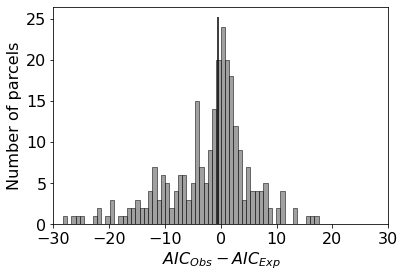

In [35]:
df_all_coefs['AIC resp-stim']= df_all_coefs['AIC_resp'] - df_all_coefs['AIC_stim']
sns.histplot(df_all_coefs['AIC resp-stim'], color = 'grey',bins = 60)
plt.xlim(-30,30)
ymin,ymax = plt.ylim()
plt.vlines(df_all_coefs['AIC resp-stim'].median(),ymin,ymax, color = 'k')
plt.xlabel(r'$AIC_{Obs} - AIC_{Exp}$')
plt.ylabel('Number of parcels')

In [56]:
len(np.where(df_all_coefs['AIC resp-stim'] < -10)[0]), len(np.where(df_all_coefs['AIC resp-stim'] > 10)[0]) # number of nodes showing a some what good improvement 
# for the observer-based (AIC resp-stim < -10) or experimenter based (AIC resp-stim > 10), resp

(44, 11)

# Plot AIC on brain

- Figure 4 in the manuscript

In [57]:
from nilearn.surface import vol_to_surf
from nilearn.plotting import plot_glass_brain, plot_surf_roi,plot_stat_map,plot_img,plot_surf_contours
import nibabel as nib
from nilearn import datasets
bg_img = datasets.load_mni152_template()
fig_save_loc = os.path.join('/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/paper_prep/figures/fig3_glm_soc_vs_nonsoc/ALL_MentalRandom')

from nilearn.datasets import fetch_surf_fsaverage
fsaverage = fetch_surf_fsaverage()

from nilearn import datasets
bg_img = datasets.load_mni152_template()

from nltools.data import Brain_Data
from nltools.mask import expand_mask, roi_to_brain

mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)


def color_rois(values):
    # from Emily Finn
    """
    This function assumes you are passing a vector "values" with the same length as the number of nodes in the atlas.
    """
    shen268 = nib.load(os.path.join(data_file_loc,"shen_2mm_268_parcellation.nii.gz"))
    shen268_data = shen268.get_fdata()
    img = np.zeros(shen268_data.shape)
    #print(shen268_data.shape)
    for roi in range(len(values)):
        itemindex = np.where(shen268_data==roi+1) # find voxels in this node (add 1 to account for zero-indexing)
        #print(len(itemindex[0]))
        img[itemindex] = values[roi] # color them by the desired value 

    affine = shen268.affine
    img_nii = nib.Nifti1Image(img, affine)
    
    return img_nii

In [59]:
nodes_coaxbill_rand_all = np.load(os.path.join(data_file_loc,'nodes_coaxbill_rand_all.npy')) 
# nodes significant across all analyses (social processing nodes) highlighted in the  S>NS GLM (notebook 2_3_1.. and black contours in 
# Figure 4 of manuscript)

In [60]:
def surf_plot1(fig,ax,nodes,params, thresh):
    # function for surface plotting model fit (AIC) data
    
    title_txt = params['title']
    txt  = params['txt']
    vmin = params['vmin']
    vmax = params['vmax']

    #LH (left hemisphere)
    ax_surf = ax[0,0]  #lateral
    texture = vol_to_surf(color_rois(nodes), fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
    surf_plot1=plot_surf_roi(fsaverage.infl_left, texture, hemi='left',cmap = cmap, colorbar=False, symmetric_cmap=True, vmin = vmin, vmax = vmax,
                                bg_map=fsaverage.sulc_left,axes = ax_surf, threshold =  thresh)#)#,vol_to_surf_kwargs={"n_samples": 10, "radius": 10, "interpolation": "nearest","kind":'ball'})

    texture_contour = vol_to_surf(color_rois(nodes_coaxbill_rand_all), fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
    plot_surf_contours(fsaverage.infl_left, texture_contour, axes = ax_surf,figure=surf_plot1, legend=True,levels = [1], colors=['k'])

    ax_surf = ax[1,0] #medial
    surf_plot2=plot_surf_roi(fsaverage.infl_left, texture, hemi='left',cmap = cmap, colorbar=False, symmetric_cmap=True, vmin = vmin, vmax = vmax,
                                bg_map=fsaverage.sulc_left, view = 'medial',axes = ax_surf, threshold =  thresh)#,vol_to_surf_kwargs={"n_samples": 10, "radius": 10, "interpolation": "nearest","kind":'ball'})
    plot_surf_contours(fsaverage.infl_left, texture_contour, axes = ax_surf,figure=surf_plot2, legend=True,levels = [1], colors=['k'])

    #RH (right hemisphere)
    ax_surf = ax[0,1] #lateral
    texture = vol_to_surf(color_rois(nodes), fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
    surf_plot3=plot_surf_roi(fsaverage.infl_right, texture, hemi='right',cmap = cmap, colorbar=True,symmetric_cmap=True, vmin = vmin, vmax = vmax,
                                bg_map=fsaverage.sulc_right,axes = ax_surf, threshold =  thresh)#)#,vol_to_surf_kwargs={"n_samples": 10, "radius": 10, "interpolation": "nearest","kind":'ball'})
    texture_contour = vol_to_surf(color_rois(nodes_coaxbill_rand_all), fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
    plot_surf_contours(fsaverage.infl_right, texture_contour, axes = ax_surf,figure=surf_plot3, legend=True,levels = [1], colors=['k'])

    surf_plot3.axes[4].text(10,.5*vmax,s=txt,fontsize=20, fontdict = {'verticalalignment':'top','horizontalalignment':'left','rotation':0})
    box = surf_plot3.axes[4].get_position()
    surf_plot3.axes[4].set_position([box.x0*.93, box.y0-.5, box.width, box.height*2])  # move a bit the bar to the right, need to divide by number of columns (to move relative to last figure only, not to overall row, else will get too far away)
    

    ax_surf = ax[1,1] #medial
    surf_plot4=plot_surf_roi(fsaverage.infl_right, texture, hemi='right',cmap = cmap, colorbar=False,symmetric_cmap=True, vmin = vmin, vmax = vmax,
                                bg_map=fsaverage.sulc_right, view ='medial',axes = ax_surf, threshold =  thresh)#)#,vol_to_surf_kwargs={"n_samples": 10, "radius": 10, "interpolation": "nearest","kind":'ball'})
    plot_surf_contours(fsaverage.infl_right, texture_contour, axes = ax_surf,figure=surf_plot4, legend=True, levels = [1], colors=['k'])#, labels=['Sig. (q<.05) across\n(a),(c),(d)'])
    
    ax[0,0].dist = 7 # change viewing distance to "zoom in" to surface plots
    ax[0,1].dist = 7
    ax[1,0].dist = 7
    ax[1,1].dist = 7

    plt.subplots_adjust(left=0,
                        bottom=0, 
                        right=.8, 
                        top=1, 
                        wspace=0.0, 
                        hspace=-.1)

In [61]:
min(df_all_coefs['AIC resp-stim']),max(df_all_coefs['AIC resp-stim']) # # getting minimum and maximum differences in AIC to define 
# max and min values in the brain plots

(-28.326528419351234, 17.53925560431162)

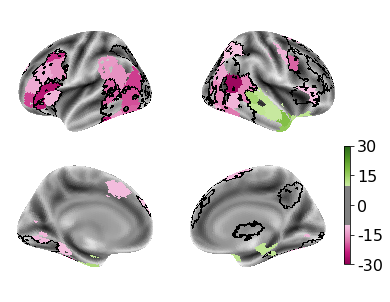

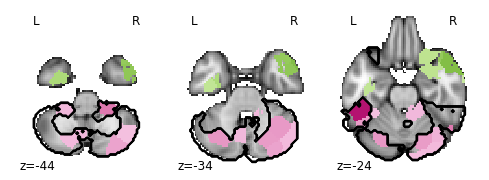

In [62]:
# surface plots
vmin,vmax = -30,30
cmap = 'PiYG' #'RdBu_r'
title_txt = 'AIC RESP V. STIM'
 
nodes = np.zeros((268,))
txt = ''  #'AIC response-\nbased LME - \nstim-based LME' #'AIC S/NS LME - M/R LME'#r"$\overline{\beta}{(diff)}$"
nodes = df_all_coefs['AIC resp-stim']
thresh = 10

fig,ax = plt.subplots(nrows=2, ncols= 2,figsize=(6,4),subplot_kw={'projection': '3d'})
params = {'title':title_txt,'txt':txt, 'vmin': vmin, 'vmax':vmax}
surf_plot1(fig,ax,nodes,params, thresh)
plt.savefig(os.path.join(fig_save_loc,f'AIC_surf_thresh{thresh}.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')
    
img = roi_to_brain(pd.Series(nodes), mask_x)
coords = [-44,-34,-24] # initial exploration
ax_plot = plot_img(img.to_nifti(), display_mode = 'z',vmin = vmin, vmax = vmax, cut_coords =coords,cmap = cmap, bg_img = bg_img,colorbar= False,threshold = thresh)
ax_plot.add_contours(color_rois(nodes_coaxbill_rand_all),linewidths=1, colors=['k'],linestyles ='-',filled=False)

plt.savefig(os.path.join(fig_save_loc,f'AIC_axial_thresh{thresh}.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')
#plt.clf()